# 공용 함수
- 수정하지 않는 것을 추천드립니다

In [30]:
from jy import get_all
import pandas as pd
from neuralprophet import NeuralProphet
import plotly.express as px


In [2]:
# 상대경로 지정 없이 원본 csv 임포트
main_df = get_all()
main_df_columns = main_df.columns
date_df = main_df.loc[:,"date"]

In [3]:
# 각 지역구와 관련된 변수들
# common은 지역 구분 없는 전체 변수
gw_vars = main_df.loc[:,main_df_columns[2:9]]
ddm_vars = main_df.loc[:,main_df_columns[9:16]]
sd_vars = main_df.loc[:,main_df_columns[16:23]]
jl_vars = main_df.loc[:,main_df_columns[23:30]]
common_vars = main_df.loc[:,main_df_columns[30:46]]

In [4]:
# 각 지역구의 따릉이 수요량 
gw_demand=main_df.loc[:,main_df_columns[46]]
ddm_demand=main_df.loc[:,main_df_columns[47]]
sd_demand=main_df.loc[:,main_df_columns[48]]
jl_demand=main_df.loc[:,main_df_columns[49]]

In [5]:
# 날짜와 수요량 컬럼을 원하는 대로 정리해주는 함수
def create_y (df_demand, date_name, y_name):
    result = pd.concat([date_df, df_demand], axis=1)
    result = result.rename(columns={"date":date_name, result.columns[1]:y_name})
    return result

In [6]:
# 변수들을 일부 샘플링한 dataframe의 리스트를 반환하는 함수
## amount는 (수요량 이외에) 추가로 샘플링할 변수의 개수 (0, 1, 2 가능. 0은 수요량만 반환)
## df_y는 날짜와 수요량이 포함된 데이터프레임. create_y 함수로 정제한 값을 넣으면 됩니다
## df_list는 추가 변수로 사용할 모든 데이터프레임들의 리스트. ~~~_vars 중 원하는 것을 리스트로 넣으면 됩니다
    ## 예시) 광진구 + 공용 변수의 경우: df_list=[gw_vars, comon_vars]
## 반환하는 값은 튜플 {"data": 데이터프레임, "name":포함된 컬럼명의 리스트} 로 이루어진 리스트입니다
    
def sample_multivariate(amount, df_y, df_list):
    samples = []
    # 데이터프레임을 하나로 통합
    df = pd.concat(df_list, axis=1)
    if amount == 0:
        # y값만 리턴
        samples.append({"data":pd.concat([df_y], axis=1),"name":[]})
    elif amount == 1:
        # sample을 한 column씩 추출
        for index in range(len(df.columns)):
            sample = pd.concat([df_y,df.loc[:,df.columns[index]]],axis=1)
            samples.append({"data":sample, "name":[df.columns[index]]})
    elif amount == 2:
        # sample을 두 column씩 추출
        for first_index in range(len(df.columns)):
            remaining_columns = df.columns[first_index+1:]
            for second_index in range(len(remaining_columns)):
                targets = [df.columns[first_index],remaining_columns[second_index]]
                sample = pd.concat([df_y,df.loc[:,targets]],axis=1)
                samples.append({"data":sample, "name":targets})
    return samples
    

In [7]:
# 데이터를 자르는 함수
# 일단은 2021년 1월 1일 기준으로 자르게 일반화 해놓았습니다

def split_sample(df):
    train = df.loc[:1095]
    test = df.loc[1096:]
    return {"train":train, "test":test}


In [8]:
def create_result(indexes):
    return pd.DataFrame(index=["Column"] + indexes)

공용 함수 End

# neural prophet을 이용한 광진구 test 입니다
- 윤호님 모델을 거의 그대로 사용
- 광진구 관련 변수를 1개씩 샘플링해서 테스트


In [9]:
# create_y로 광진구 수요량 데이터 정제
gw_y = create_y(gw_demand,"ds","y")


In [10]:
# 광진구 관련 데이터(gw_vars)에서 1개씩 sampling하여 test_dfs 제작
test_dfs = sample_multivariate(2,gw_y,[gw_vars])

In [11]:
# test_dfs가 제대로 샘플링 되었는 지 확인
# 총 6개의 변수가 있으므로 6개의 데이터프레임이 포함된 리스트가 생성되었을 겁니다
for test_df in test_dfs:
    print(test_df["data"].head(1))

         ds      y  air_GW  real_pop_GW
0  1/1/2018  0.592    42.0      421.214
         ds      y  air_GW  pop_GW
0  1/1/2018  0.592    42.0  357785
         ds      y  air_GW  pop_male_GW
0  1/1/2018  0.592    42.0       161143
         ds      y  air_GW  pop_female_GW
0  1/1/2018  0.592    42.0         174428
         ds      y  air_GW  mvpop_GW
0  1/1/2018  0.592    42.0    260642
         ds      y  air_GW  station_GW
0  1/1/2018  0.592    42.0          37
         ds      y  real_pop_GW  pop_GW
0  1/1/2018  0.592      421.214  357785
         ds      y  real_pop_GW  pop_male_GW
0  1/1/2018  0.592      421.214       161143
         ds      y  real_pop_GW  pop_female_GW
0  1/1/2018  0.592      421.214         174428
         ds      y  real_pop_GW  mvpop_GW
0  1/1/2018  0.592      421.214    260642
         ds      y  real_pop_GW  station_GW
0  1/1/2018  0.592      421.214          37
         ds      y  pop_GW  pop_male_GW
0  1/1/2018  0.592  357785       161143
         ds      y

In [12]:
# create_result 함수로 result 생성
result = create_result(["MAE","MAE_val"])
# result가 잘 생성되었는 지 확인

print(result)

Empty DataFrame
Columns: []
Index: [Column, MAE, MAE_val]


In [13]:
# for문을 통해 모델 생성
for index, test_df in enumerate(test_dfs):

    # 샘플링 된 컬럼명
    columns = test_df["name"]

    # test_df로부터 test, train 데이터셋 분리
    splitted = split_sample(test_df["data"])
    test = splitted["test"]
    train = splitted["train"]

    # 모델 생성
    m = NeuralProphet(
        growth='linear', # 추세 유형 설정(linear, discontinuous, off 중 선택 가능)
        yearly_seasonality=True, #년간 계절성 설정
        weekly_seasonality=True, #주간 계절성 설정
        daily_seasonality=True, #일간 계절성 설정
        batch_size=32,#배치 사이즈 설정
        epochs=30,#학습 횟수 설정
        learning_rate=0.1, # 학습률 설정
    )
    # 독립 변인(변수) 추가 및 정규화
    # regressor의 names로는 샘플링된 컬럼명인 columns를 사용했습니다
    m = m.add_lagged_regressor(names=columns, normalize="minmax") 
    m.add_seasonality(name='monthly', period=30.5, fourier_order=5)

    # 학습 수행
    metrics = m.fit(train, freq='h', validation_df=test)
    
    # 기록
    # result의 첫 행은 Column 명입니다!
    result[index] = [columns,metrics.loc[29,"MAE"],metrics.loc[29,"MAE_val"]]





INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.909% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency h is different than major frequency D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.909% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency h is different than major frequency D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.909% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency h is different than major frequency D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.909% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency h is different than major frequency D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.909% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency h is different than major frequency D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.909% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency h is different than major frequency D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.909% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency h is different than major frequency D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.909% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency h is different than major frequency D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.909% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency h is different than major frequency D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.909% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency h is different than major frequency D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.909% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency h is different than major frequency D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.909% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency h is different than major frequency D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.909% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency h is different than major frequency D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.909% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency h is different than major frequency D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.909% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency h is different than major frequency D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.909% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency h is different than major frequency D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.909% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency h is different than major frequency D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.909% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency h is different than major frequency D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.909% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency h is different than major frequency D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.909% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency h is different than major frequency D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.909% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency h is different than major frequency D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [14]:
# result 확인
print(result)


                            0                 1                      2   \
Column   [air_GW, real_pop_GW]  [air_GW, pop_GW]  [air_GW, pop_male_GW]   
MAE                   1.222752          1.283841               1.219903   
MAE_val               3.113895          2.111124               6.737593   

                              3                   4                     5   \
Column   [air_GW, pop_female_GW]  [air_GW, mvpop_GW]  [air_GW, station_GW]   
MAE                      1.27127            1.252315              1.245043   
MAE_val                 2.296373            3.058297              2.916279   

                            6                           7   \
Column   [real_pop_GW, pop_GW]  [real_pop_GW, pop_male_GW]   
MAE                   1.263639                    1.219491   
MAE_val               2.773694                    4.810446   

                                   8                        9   ...  \
Column   [real_pop_GW, pop_female_GW]  [real_pop_GW, mvpop_GW]  ..

In [15]:
result.to_csv("../results/gw_twovars.csv")

In [23]:
best_columns = ["pop_GW","pop_female_GW"]
best_df = pd.concat([gw_y,gw_vars.loc[:,best_columns]],axis=1)

In [28]:
best_splitted = split_sample(best_df)
best_train = best_splitted["train"]
best_test = best_splitted["test"]

In [29]:
best_m =  NeuralProphet(

    growth='linear', # 추세 유형 설정(linear, discontinuous, off 중 선택 가능)

    yearly_seasonality=True, #년간 계절성 설정

    weekly_seasonality=True, #주간 계절성 설정

    daily_seasonality=True, #일간 계절성 설정

    batch_size=32,#배치 사이즈 설정

    epochs=30,#학습 횟수 설정

    learning_rate=0.1, # 학습률 설정

)

#독립 변인(변수) 추가 및 정규화
best_m = best_m.add_lagged_regressor(names=best_columns, normalize="minmax") 
best_m.add_seasonality(name='monthly', period=30.5, fourier_order=5)

best_metrics = best_m.fit(best_train,freq="D",validation_df=best_test)

INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.909% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [36]:
metrics.tail(5)

,MAE_val,RMSE_val,Loss_val,RegLoss_val,epoch,MAE,RMSE,Loss,RegLoss
25,2.141696,2.687858,0.029353,0.0,25,1.394427,1.863164,0.011576,0.0
26,2.191198,2.748778,0.030698,0.0,26,1.281343,1.771580,0.010643,0.0
27,2.047098,2.624215,0.027979,0.0,27,1.297201,1.788281,0.010963,0.0
28,2.095972,2.659816,0.028743,0.0,28,1.265272,1.728151,0.010101,0.0
29,2.091019,2.656279,0.028667,0.0,29,1.278018,1.748551,0.010337,0.0


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.726% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.727% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 35it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


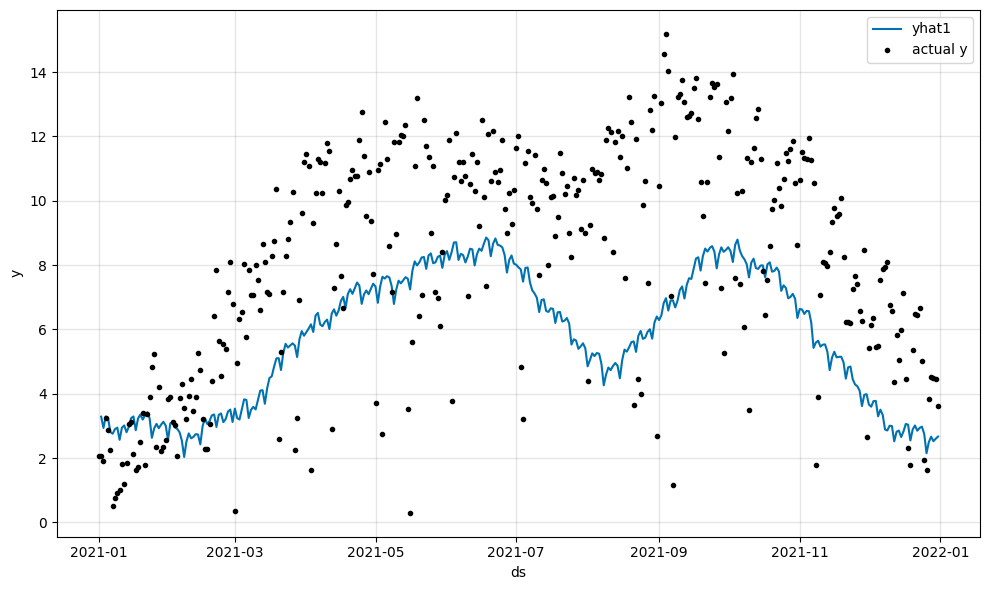

In [48]:
forecast = best_m.predict(df=best_test)
fig = best_m.plot(forecast[['ds', 'y', 'yhat1']])
# forecast

In [50]:
px.line(best_metrics, y=["MAE","MAE_val"],width=800,height=400)